In [1]:
from pathlib import Path
from typing import Union, Callable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as tfk
from sklearn import datasets
from sklearn.externals import joblib
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from dlsvm.models import DnnSvm
from dlsvm.tools import build_model, label_2_onehot

In [2]:
out = Path('./0520_digits_softmax')
if not out.exists():
    out.mkdir(parents=True)

In [3]:
sns.set()

### Load dataset

In [4]:
digits = datasets.load_digits()

In [5]:
digits = datasets.load_digits()
X = digits.data.astype(np.float32)
y = digits.target.astype(np.float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_, X_train_val, y_train_, y_train_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
y_train_ = label_2_onehot(y_train_)
y_train_val = label_2_onehot(y_train_val)

### Build model

In [8]:
dlsvm = build_model(
    n_class=len(digits.target_names),
    n_in=len(digits.data[0]),
    n_h=128,
    activation='relu',
    kernel_initializer='he_uniform',
    penalty=1.,
    softmax=True
)

In [9]:
batch_size = 64
epochs = 50
learning_rate = 1e-3
patience = 5
loss = 'categorical_crossentropy'

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
dlsvm.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

In [11]:
es_cb = tfk.callbacks.EarlyStopping(
    monitor='val_loss', patience=patience, mode='auto'
)
tb_cb = tfk.callbacks.TensorBoard(log_dir=str(out))
cl_cb = tfk.callbacks.CSVLogger(
    str(out.joinpath('train.log.csv')), separator=',', append=False
)
cp_cb = tfk.callbacks.ModelCheckpoint(
    str(out.joinpath('model.weights.h5')), monitor='val_acc', verbose=0,
    save_best_only=True, save_weights_only=False, mode='auto', period=1
)

### Train model

In [12]:
history = dlsvm.fit(
    *(X_train_, y_train_),
    validation_data=(X_train_val, y_train_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tb_cb, cl_cb, cp_cb]
)

Train on 1149 samples, validate on 288 samples
Epoch 1/50
1149/1149 [==============================] - 1s 1ms/sample - loss: 9.1108 - acc: 0.2376 - val_loss: 4.4717 - val_acc: 0.3785
Epoch 2/50
1149/1149 [==============================] - 0s 152us/sample - loss: 2.5623 - acc: 0.5013 - val_loss: 1.4632 - val_acc: 0.6701
Epoch 3/50
1149/1149 [==============================] - 0s 161us/sample - loss: 1.0926 - acc: 0.7493 - val_loss: 0.8281 - val_acc: 0.7951
Epoch 4/50
1149/1149 [==============================] - 0s 169us/sample - loss: 0.6693 - acc: 0.8399 - val_loss: 0.5572 - val_acc: 0.8646
Epoch 5/50
1149/1149 [==============================] - 0s 168us/sample - loss: 0.4786 - acc: 0.8773 - val_loss: 0.4454 - val_acc: 0.8819
Epoch 6/50
1149/1149 [==============================] - 0s 139us/sample - loss: 0.3644 - acc: 0.8990 - val_loss: 0.3466 - val_acc: 0.8958
Epoch 7/50
1149/1149 [==============================] - ETA: 0s - loss: 0.2938 - acc: 0.924 - 0s 171us/sample - loss: 0.2861 - 

In [13]:
df_result = pd.DataFrame(history.history)

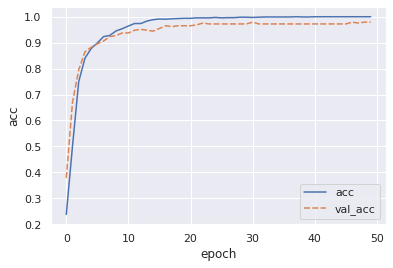

In [14]:
sns.lineplot(data=df_result[['acc', 'val_acc']])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.savefig(out.joinpath('acc_logs.pdf'))

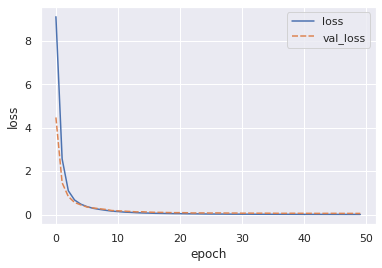

In [15]:
sns.lineplot(data=df_result[['loss', 'val_loss']])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(out.joinpath('loss_logs.pdf'))

In [16]:
dlsvm.load_weights(str(out.joinpath('model.weights.h5')))

In [17]:
dlsvm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               8320      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 9,610
Trainable params: 9,610
Non-trainable params: 0
_________________________________________________________________


### Performance of model

In [18]:
df_train = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_train), axis=-1), y_true=y_train, output_dict=True)
)
print('Train perfomance of model')
print(df_train)
df_train.to_csv(out.joinpath('train-performance.csv'))

Train perfomance of model
             0.0         1.0         2.0         3.0         4.0    5.0  \
f1-score     1.0    0.987097    0.996516    0.993333    0.988848    1.0   
precision    1.0    0.980769    1.000000    0.986755    0.992537    1.0   
recall       1.0    0.993506    0.993056    1.000000    0.985185    1.0   
support    145.0  154.000000  144.000000  149.000000  135.000000  135.0   

             6.0         7.0         8.0         9.0    micro avg  \
f1-score     1.0    0.996540    0.986111    0.996416     0.994433   
precision    1.0    1.000000    0.986111    1.000000     0.994433   
recall       1.0    0.993103    0.986111    0.992857     0.994433   
support    146.0  145.000000  144.000000  140.000000  1437.000000   

             macro avg  weighted avg  
f1-score      0.994486      0.994439  
precision     0.994617      0.994473  
recall        0.994382      0.994433  
support    1437.000000   1437.000000  


In [19]:
df_test = pd.DataFrame(
    classification_report(y_pred=np.argmax(dlsvm.predict(X_test), axis=-1), y_true=y_test, output_dict=True)
)
print('Test perfomance of model')
print(df_test)
df_test.to_csv(out.joinpath('test-performance.csv'))

Test perfomance of model
            0.0        1.0        2.0        3.0        4.0        5.0  \
f1-score    1.0   0.982456   0.927536   0.953846   0.989247   0.957447   
precision   1.0   0.965517   0.888889   1.000000   0.978723   0.957447   
recall      1.0   1.000000   0.969697   0.911765   1.000000   0.957447   
support    33.0  28.000000  33.000000  34.000000  46.000000  47.000000   

                 6.0   7.0        8.0        9.0   micro avg   macro avg  \
f1-score    0.985507   1.0   0.947368   0.975610    0.972222    0.971902   
precision   1.000000   1.0   1.000000   0.952381    0.972222    0.974296   
recall      0.971429   1.0   0.900000   1.000000    0.972222    0.971034   
support    35.000000  34.0  30.000000  40.000000  360.000000  360.000000   

           weighted avg  
f1-score       0.972199  
precision      0.973568  
recall         0.972222  
support      360.000000  


In [20]:
np.argmax(dlsvm.predict(X_train), axis=-1)

array([6, 0, 0, ..., 2, 7, 1])

In [21]:
np.argmax(dlsvm.predict(X_test), axis=-1)

array([6, 9, 3, 7, 2, 1, 5, 2, 5, 2, 1, 9, 4, 0, 4, 2, 3, 7, 8, 8, 4, 3,
       9, 7, 5, 6, 3, 5, 6, 3, 4, 9, 1, 4, 4, 6, 9, 4, 7, 6, 6, 9, 1, 3,
       6, 1, 3, 0, 6, 5, 5, 1, 9, 5, 6, 0, 9, 0, 0, 1, 0, 4, 5, 2, 4, 5,
       7, 0, 7, 5, 9, 9, 5, 4, 7, 0, 4, 5, 5, 9, 9, 0, 2, 3, 8, 0, 6, 4,
       4, 9, 1, 2, 8, 3, 5, 2, 9, 0, 4, 4, 4, 3, 5, 3, 1, 3, 5, 9, 4, 2,
       7, 7, 4, 4, 1, 9, 2, 7, 8, 7, 2, 6, 9, 4, 0, 7, 2, 7, 5, 8, 7, 5,
       7, 7, 0, 6, 6, 4, 2, 8, 0, 9, 4, 6, 9, 9, 6, 9, 0, 9, 5, 6, 6, 0,
       6, 4, 2, 9, 3, 9, 7, 2, 9, 0, 4, 5, 3, 6, 5, 9, 9, 8, 4, 2, 1, 3,
       7, 7, 2, 2, 3, 9, 8, 0, 3, 2, 2, 5, 6, 9, 9, 4, 1, 2, 4, 2, 3, 6,
       4, 8, 5, 9, 5, 7, 2, 9, 4, 8, 1, 5, 4, 4, 9, 6, 1, 8, 6, 0, 4, 5,
       2, 7, 4, 6, 4, 5, 6, 0, 3, 2, 3, 6, 7, 1, 5, 1, 4, 7, 6, 5, 8, 5,
       5, 1, 4, 1, 8, 8, 9, 9, 7, 6, 2, 2, 2, 3, 4, 8, 5, 3, 6, 0, 9, 7,
       7, 0, 1, 0, 4, 5, 1, 5, 3, 6, 0, 4, 1, 0, 0, 2, 6, 5, 9, 7, 3, 5,
       5, 9, 9, 8, 5, 3, 3, 2, 0, 5, 8, 3, 4, 0, 2,